## **Mushroom Classification**
HW 02 -- Working with Individual Classifiers


Upasana Mehta - um2024 - um2024@nyu.edu

This is a mushroom type classification deciphering if the mushroom is "edible" or "poisonous". I started with a total of 23 variables(22 independent and 1 dependent variable) and 8124 observations. But after EDA the datset is cleaned,  normalised and all the corelated variables have been removed for unbiased result. Now we are left with 18 dependent variables and 1 dependent.

After doing the EDA, I took the dataframe and converted it to an excel file. Taking that input as an excel file for HW 02.

File name - AfterEDA_dataset.csv

In [1]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘future.apply’, ‘lava’, ‘prodlim’, ‘ipred’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [2]:
library(caret)
library(rpart)
library(dplyr)

Loading required package: ggplot2

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
mushroomdata <- read.csv("AfterEDA_dataset.csv")

In [4]:
glimpse(mushroomdata)

Rows: 8,124
Columns: 19
$ class                    <int> 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, …
$ cap.shape                <int> 6, 6, 1, 6, 6, 6, 1, 1, 6, 1, 6, 6, 1, 6, 6, …
$ cap.surface              <int> 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 1, …
$ cap.color                <int> 5, 10, 9, 9, 4, 10, 9, 9, 9, 10, 10, 10, 10, …
$ bruises                  <int> 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, …
$ odor                     <int> 7, 1, 4, 7, 6, 1, 1, 4, 7, 1, 4, 1, 1, 7, 6, …
$ gill.size                <int> 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, …
$ gill.color               <int> 5, 5, 6, 6, 5, 6, 3, 6, 8, 3, 3, 6, 11, 5, 6,…
$ stalk.shape              <int> 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, …
$ stalk.root               <int> 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, …
$ stalk.surface.above.ring <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, …
$ stalk.surface.below.ring <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, …
$ stalk.color.ab

In [5]:
#As we can see we have 8124 observations and 19 columns which has 1 dependent variable called "class"
# and 17 independent variables.

Now we need to prepare the data before creating the first Classification Model. This is done by splitting the data into Testing Data and Training Data. 70% of the total data were randomly stored as training set and 30% as testing set.

In [6]:
set.seed(43)
randomized=mushroomdata[sample(1:nrow(mushroomdata),nrow(mushroomdata)),] #Random sampling for creating test and train data
tridx=sample(1:nrow(mushroomdata),0.7*nrow(mushroomdata),replace=F) 
trdf=randomized[tridx,] # Training data set
tstdf=randomized[-tridx,] # Testing data set

In [7]:
#Now we will check if the distribution is similar in the actual data, training data and testing data

In [8]:
table(mushroomdata$class)/nrow(mushroomdata)



        1         2 
0.5179714 0.4820286 

In [9]:
table(trdf$class)/nrow(trdf)


        1         2 
0.5172353 0.4827647 

In [10]:
table(tstdf$class)/nrow(tstdf)


        1         2 
0.5196883 0.4803117 

In [11]:
# As we can see the distribution is almost same. So the training dataset and testing dataset is a proper 
# representation of the actual data 

**Variance Estimation**

Variance measures how spread out the data in a sample is. If
the variance is small, this means that all the measurements are close to the mean and there is not a lot of variability. If the variance is large, the data is very spread out and highly variable.

In [12]:
varEst_tridx=sample(1:nrow(trdf), 0.9*nrow(trdf), replace=F) # Taking 90% of the total number of samples
varEst_trdf=trdf[varEst_tridx,] # Training data for variance estimation
varEst_tstdf=trdf[-varEst_tridx,] # Testing data for variance estimation

In [13]:
varEst=function(trdf,tstdf,percent,type){
    target_idx=which(names(trdf)=="class")
    acc_varEstp=c(); # Initialize a variable to store the accuracies computed in the loop
    for(i in 1:10){
        varEstp_tridx=sample(1:nrow(trdf), percent/100*nrow(trdf), replace=F) # Take samples, percent% of the data
        varEstp_trdf=trdf[varEstp_tridx,]
        
        # For logistic
        if(type=="glm"){
            mn_model_varEstp=glm(formstr, varEstp_trdf,family=gaussian()) #Train a Logistic model
            pred_varEstp=predict(mn_model_varEstp, tstdf[,-target_idx], type="response") # Predict with variance estimation partition
        } 
        
        # For SVM
        else if(type=="svm"){
            svm_model_varEstp = svm(class~., varEstp_trdf, scale = FALSE)
            pred_varEstp1=predict(svm_model_varEstp, tstdf[,-target_idx])
            pred_varEstp = ifelse(pred_varEstp1 > 0.5, "1", "0")
        }
            
        # For Tree
        else if(type=="rpart"){ 
            tree_model_varEstp=rpart(formstr, varEstp_trdf,method = 'class')
            pred_varEstp=predict(tree_model_varEstp, tstdf[,-target_idx], type="class")
            
        }
            
        # For KNN 
        else if(type=="knn"){
            trclass=factor(varEstp_trdf[,target_idx])
            tstclass=factor(tstdf[,target_idx])
            pred_varEstp=knn(varEstp_trdf[,-target_idx], tstdf[,-target_idx], trclass, k = 15, prob=TRUE)
        } 
        
        else {
            print("Type should be Logistic or tree or KNN or SVM")
            return()
        }
        u_varEstp=union(pred_varEstp, tstdf[,target_idx]) # Avoids issues when number of classes are not equal
        t_varEstp=table(factor(pred_varEstp, u_varEstp), factor(tstdf[,target_idx],u_varEstp))
        mn_cfm_varEstp=confusionMatrix(t_varEstp) # Confusion Matrix
        mn_acc_varEstp=mn_cfm_varEstp$overall[["Accuracy"]] # Accuracy of predictions
        acc_varEstp=c(acc_varEstp,mn_acc_varEstp) # Store
    }
    mean_varEstp=signif(mean(acc_varEstp),4)
    var_varEstp=signif(var(acc_varEstp),4)
    varEstp=data.frame(mean_varEstp,var_varEstp)
    names(varEstp)=c("Mean of Accuracies","Variance of Accuracies")
    return(t(varEstp))
}

In [14]:
# We will use this function to caluculate Variance Estimation for 4 algorithms we are going to work on

I will be running 4 classification algorithms and my aim is to determine which among these 4 classification models - Logistic Regression, SVM, Decision Tree and KNN is a better performing model and is able to classify a mushroom more accurately if it is edible or poisonous.

**Logistic Regression**

In [15]:
# Create a logistic regression model 
formstr="class~." # Formula argument with all features
glm_model1 = glm(formstr,trdf,family=gaussian()) # Train the model

In [16]:
summary(glm_model1)


Call:
glm(formula = formstr, family = gaussian(), data = trdf)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.35356  -0.12741  -0.00467   0.12791   1.12745  

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.632216   0.067548  38.968  < 2e-16 ***
cap.shape                 0.001173   0.002329   0.504    0.614    
cap.surface               0.032514   0.003292   9.877  < 2e-16 ***
cap.color                -0.009046   0.001760  -5.141 2.83e-07 ***
bruises                  -0.030049   0.014407  -2.086    0.037 *  
odor                     -0.023239   0.002257 -10.297  < 2e-16 ***
gill.size                 0.576213   0.014852  38.798  < 2e-16 ***
gill.color               -0.022028   0.001487 -14.812  < 2e-16 ***
stalk.shape              -0.203986   0.013727 -14.861  < 2e-16 ***
stalk.root               -0.113529   0.005585 -20.327  < 2e-16 ***
stalk.surface.above.ring -0.165639   0.007403 -22.376  < 2e-

In [17]:
# Predict using the train data (Learning Phase)
glm_pred1_tr_=predict(glm_model1,trdf[, -which(names(trdf)=="class")], type = "response")
# glm_pred1_tr_ will the predicted values from 1 to 2(can be any value, decimal also) as it is a binomial distribution. 
# To make the glm_pred1_tr_ in 1 and 2, using the below if loop. 
glm_pred1_tr = ifelse(glm_pred1_tr_ > 1, "2", "1")

In [18]:
print(glm_pred1_tr)

6746 6362 2719 7439 5215 7446 5760 1717 5630 3722 6061  192 2571 1760  890 6550 
 "2"  "2"  "1"  "2"  "2"  "1"  "2"  "2"  "2"  "2"  "2"  "2"  "1"  "2"  "2"  "2" 
7331   23 1651 2029 2458   78 4339  297 5920  143 2845  696 2004 5246 7772 3224 
 "2"  "2"  "2"  "2"  "1"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2" 
 146 4744 4552  910 2519 5495 2688 7146 6780  132 3369 3411  319   68 4145  672 
 "2"  "2"  "2"  "2"  "2"  "1"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "1"  "2"  "2" 
5459  447 3906 6377 6897 6410 3163  363  643 6889 5806 6087 8067 1394 1361 7402 
 "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "1"  "2"  "2"  "2"  "2"  "2"  "2"  "2" 
6756 6367 7517 7241 6712 1350 1168 1920 5872 6484  815 4210 4442 6050  325 5256 
 "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "1"  "2" 
7984 3391 2531 5082 5321  127 5291 4370 3392 2078  748 7607 1542 1605  627 3389 
 "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "2"  "1"  "1"  "2"  "2" 
2600 1708 4072 1390 3360 701

In [19]:
glm_cfm1_tr=confusionMatrix(table(trdf[, which(names(trdf)=="class")], glm_pred1_tr)) # Confusion Matrix for train data

In [20]:
print("Learning Phase Confusion Matrix")
glm_cfm1_tr

[1] "Learning Phase Confusion Matrix"


Confusion Matrix and Statistics

   glm_pred1_tr
       1    2
  1  628 2313
  2   22 2723
                                          
               Accuracy : 0.5893          
                 95% CI : (0.5764, 0.6022)
    No Information Rate : 0.8857          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2             
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9662          
            Specificity : 0.5407          
         Pos Pred Value : 0.2135          
         Neg Pred Value : 0.9920          
             Prevalence : 0.1143          
         Detection Rate : 0.1104          
   Detection Prevalence : 0.5172          
      Balanced Accuracy : 0.7534          
                                          
       'Positive' Class : 1               
                                          

In [21]:
glm_acc1_tr=round(glm_cfm1_tr$overall[["Accuracy"]],4) # Accuracy of predictions with train data

In [22]:
print(paste("Classification accuracy of learning phase =",glm_acc1_tr))

[1] "Classification accuracy of learning phase = 0.5893"


In [23]:
# Predict using the test data (Generalization Phase)
glm_pred1_tst_=predict(glm_model1,tstdf[, -which(names(tstdf)=="class")], type="response")
# glm_pred1_tr_ will the predicted values from 0 to 1(can be any value, decimal also) as it is a binomial distribution. 
# To make the glm_pred1_tr_ in 1 and 0, using the below if loop.
glm_pred1_tst = ifelse(glm_pred1_tst_ > 1, "2", "1")

In [24]:
glm_cfm1_tst=confusionMatrix(table(tstdf[, which(names(tstdf)=="class")], glm_pred1_tst)) # Confusion Matrix for test data

In [25]:
print("Generalization Phase Confusion Matrix")
glm_cfm1_tst

[1] "Generalization Phase Confusion Matrix"


Confusion Matrix and Statistics

   glm_pred1_tst
       1    2
  1  253 1014
  2   10 1161
                                          
               Accuracy : 0.58            
                 95% CI : (0.5601, 0.5997)
    No Information Rate : 0.8921          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1851          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9620          
            Specificity : 0.5338          
         Pos Pred Value : 0.1997          
         Neg Pred Value : 0.9915          
             Prevalence : 0.1079          
         Detection Rate : 0.1038          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.7479          
                                          
       'Positive' Class : 1               
                                          

In [26]:
glm_acc1_tst=round(glm_cfm1_tst$overall[["Accuracy"]],4) # Accuracy of predictions with test data

In [27]:
print(paste("Classification accuracy of generalization phase =",glm_acc1_tst))

[1] "Classification accuracy of generalization phase = 0.58"


In [28]:
# Check for over-fitting. Criteria: Accuracy change from train to test > 25%
glm_model1_isOF=abs((glm_acc1_tr-glm_acc1_tst)/glm_acc1_tr)

In [29]:
glm_model1_isOF=round(glm_model1_isOF,4)

In [30]:
print(paste("Accuracy drop from training data to test data is",glm_model1_isOF*100,"%"))

[1] "Accuracy drop from training data to test data is 1.58 %"


In [31]:
if(glm_model1_isOF>0.25) print("Model is over-fitting") else print("Model is not over-fitting")

[1] "Model is not over-fitting"


In [32]:
glm_PM1_tr=glm_cfm1_tr$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]

In [33]:
print("Logistic-Regression Learning-Phase Performance Parameters:")
glm_PM1_tr

[1] "Logistic-Regression Learning-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.7534304         0.2135328         0.9661538         0.5407069 
           Recall 
        0.9661538

In [34]:
glm_prob1_tr=predict(glm_model1, trdf[,-which(names(trdf)=="class")], type="response")

In [35]:
require(pROC)

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [36]:
glm_AUC1_tr = roc(trdf[,which(names(trdf)=="class")],glm_prob1_tr)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [37]:
print(paste("Logistic-Regression Learning-Phase AUC:",round(glm_AUC1_tr$auc,4)))

[1] "Logistic-Regression Learning-Phase AUC: 0.9552"


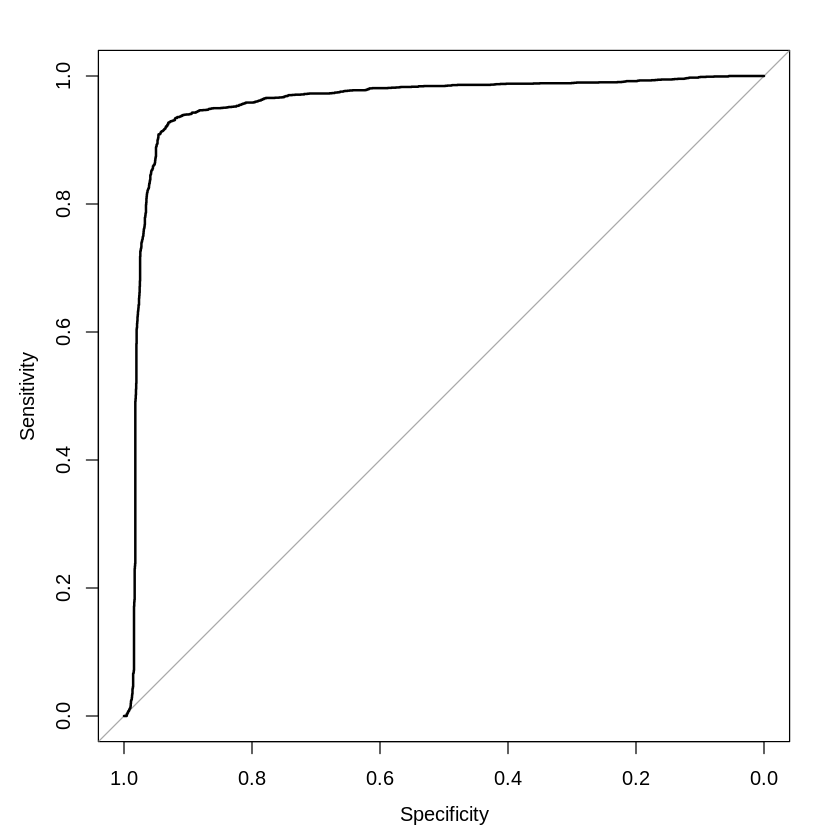

In [38]:
# ROC curves
plot.roc(glm_AUC1_tr)

In [39]:
# Generalization Phase
glm_PM1_tst=glm_cfm1_tst$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]

In [40]:
print("Logistic-Regression Generalization-Phase Performance Parameters:")
glm_PM1_tst

[1] "Logistic-Regression Generalization-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.7478851         0.1996843         0.9619772         0.5337931 
           Recall 
        0.9619772

In [41]:
glm_prob1_tst=predict(glm_model1, tstdf[,-which(names(tstdf)=="class")], type="response")

In [42]:
glm_AUC1_tst=roc(tstdf[, which(names(tstdf)=="class")], glm_prob1_tst)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [43]:
print(paste("Logistic-Regression Generalization-Phase AUC:", round(glm_AUC1_tst$auc,4)))

[1] "Logistic-Regression Generalization-Phase AUC: 0.9555"


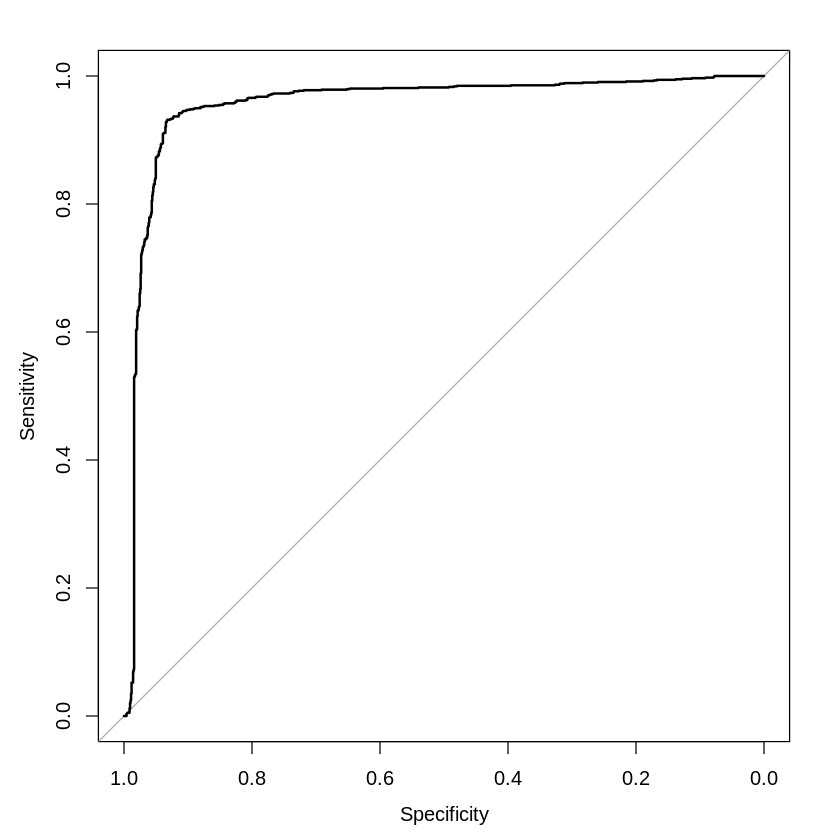

In [44]:
# ROC curves
plot.roc(glm_AUC1_tst)

In [45]:
glm_cfm1_tst

Confusion Matrix and Statistics

   glm_pred1_tst
       1    2
  1  253 1014
  2   10 1161
                                          
               Accuracy : 0.58            
                 95% CI : (0.5601, 0.5997)
    No Information Rate : 0.8921          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1851          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9620          
            Specificity : 0.5338          
         Pos Pred Value : 0.1997          
         Neg Pred Value : 0.9915          
             Prevalence : 0.1079          
         Detection Rate : 0.1038          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.7479          
                                          
       'Positive' Class : 1               
                                          

In [46]:
glm_varEst30=varEst(varEst_trdf, varEst_tstdf, 30, type="glm") # Variance estimation using 30% of the data
glm_varEst60=varEst(varEst_trdf, varEst_tstdf, 60, type="glm") # Variance estimation using 60% of the data
glm_varEst100=varEst(varEst_trdf, varEst_tstdf, 100, type="glm") # Variance estimation using 100% of the data

In [47]:
print("Logistic-Regression Variance Estimation using 30% of data:")
glm_varEst30

[1] "Logistic-Regression Variance Estimation using 30% of data:"


Mean of Accuracies,0
Variance of Accuracies,0


In [48]:
print("Logistic-Regression Variance Estimation using 60% of data:")
glm_varEst60

[1] "Logistic-Regression Variance Estimation using 60% of data:"


Mean of Accuracies,0
Variance of Accuracies,0


In [49]:
print("Logistic-Regression Variance Estimation using 100% of data:")
glm_varEst100

[1] "Logistic-Regression Variance Estimation using 100% of data:"


Mean of Accuracies,0
Variance of Accuracies,0


**SVM**

In [50]:
require(e1071)

Loading required package: e1071



In [51]:
svm_model1 = svm(class~., data = trdf,method = "svmLinear")

In [52]:
print(svm_model1)


Call:
svm(formula = class ~ ., data = trdf, method = "svmLinear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05555556 
    epsilon:  0.1 


Number of Support Vectors:  454



In [53]:
# Predict using train data (Learning Phase)
svm_pred1_tr=predict(svm_model1, trdf[, -which(names(trdf)=="class")])
svm_pred1_tr1 = ifelse(svm_pred1_tr > 1, "2", "1")

Since this is a binomial distribution and I have 2 values for class variable - "1" and "2", so I would like to round off the value to 2 if the svm_pred1_tr is greater than 1.

In [54]:
svm_cfm1_tr=confusionMatrix(table(trdf$class,svm_pred1_tr1)) # Confusion Matrix for train data


In [55]:
print("SVM Learning Phase Confusion Matrix")
svm_cfm1_tr

[1] "SVM Learning Phase Confusion Matrix"


Confusion Matrix and Statistics

   svm_pred1_tr1
       1    2
  1  787 2154
  2    0 2745
                                          
               Accuracy : 0.6212          
                 95% CI : (0.6084, 0.6338)
    No Information Rate : 0.8616          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2608          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.5603          
         Pos Pred Value : 0.2676          
         Neg Pred Value : 1.0000          
             Prevalence : 0.1384          
         Detection Rate : 0.1384          
   Detection Prevalence : 0.5172          
      Balanced Accuracy : 0.7802          
                                          
       'Positive' Class : 1               
                                          

In [56]:
svm_acc1_tr=round(svm_cfm1_tr$overall[["Accuracy"]],4)

In [57]:
print(paste("SVM Learning Phase Accuracy =",svm_acc1_tr))

[1] "SVM Learning Phase Accuracy = 0.6212"


In [58]:
# Predict using test data (Generalization Phase)
svm_pred1_tst=predict(svm_model1, tstdf[, -which(names(tstdf)=="class")], type="class")
svm_pred1_tst1 = ifelse(svm_pred1_tst > 1, "2", "1")

In [59]:
svm_cfm1_tst=confusionMatrix(table(tstdf[, which(names(tstdf)=="class")], svm_pred1_tst1)) # Confusion Matrix for test data


In [60]:
print("SVM Generalization Phase Confusion Matrix")
svm_cfm1_tst

[1] "SVM Generalization Phase Confusion Matrix"


Confusion Matrix and Statistics

   svm_pred1_tst1
       1    2
  1  357  910
  2    0 1171
                                         
               Accuracy : 0.6267         
                 95% CI : (0.6072, 0.646)
    No Information Rate : 0.8536         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2737         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 1.0000         
            Specificity : 0.5627         
         Pos Pred Value : 0.2818         
         Neg Pred Value : 1.0000         
             Prevalence : 0.1464         
         Detection Rate : 0.1464         
   Detection Prevalence : 0.5197         
      Balanced Accuracy : 0.7814         
                                         
       'Positive' Class : 1              
                                         

In [61]:
svm_acc1_tst=round(svm_cfm1_tst$overall[["Accuracy"]],4) # Accuracy 

In [62]:
print(paste("SVM Generalization Phase Accuracy =",svm_acc1_tst))

[1] "SVM Generalization Phase Accuracy = 0.6267"


In [63]:
# Check for over-fitting. Criteria: Accuracy change from train to test > 25%
svm_model1_isOF=abs((svm_acc1_tr-svm_acc1_tst)/svm_acc1_tr)
svm_model1_isOF=round(svm_model1_isOF,4)
print(paste("Accuracy drop from training data to test data is",svm_model1_isOF*100,"%"))

[1] "Accuracy drop from training data to test data is 0.89 %"


In [64]:
if(svm_model1_isOF>0.25) print("Model is over-fitting") else print("Model is not over-fitting")

[1] "Model is not over-fitting"


In [65]:
svm_PM1_tr=svm_cfm1_tr$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]


In [66]:
print("SVM Learning-Phase Performance Parameters:")
svm_PM1_tr

[1] "SVM Learning-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.7801592         0.2675961         1.0000000         0.5603184 
           Recall 
        1.0000000

In [67]:
svm_prob1_tr=predict(svm_model1, trdf[, -which(names(trdf)=="class")],)

In [68]:
svm_AUC1_tr=roc(trdf[, which(names(trdf)=="class")], svm_prob1_tr)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [69]:
print(paste("SVM Learning-Phase AUC:", round(svm_AUC1_tr$auc, 4)))

[1] "SVM Learning-Phase AUC: 1"


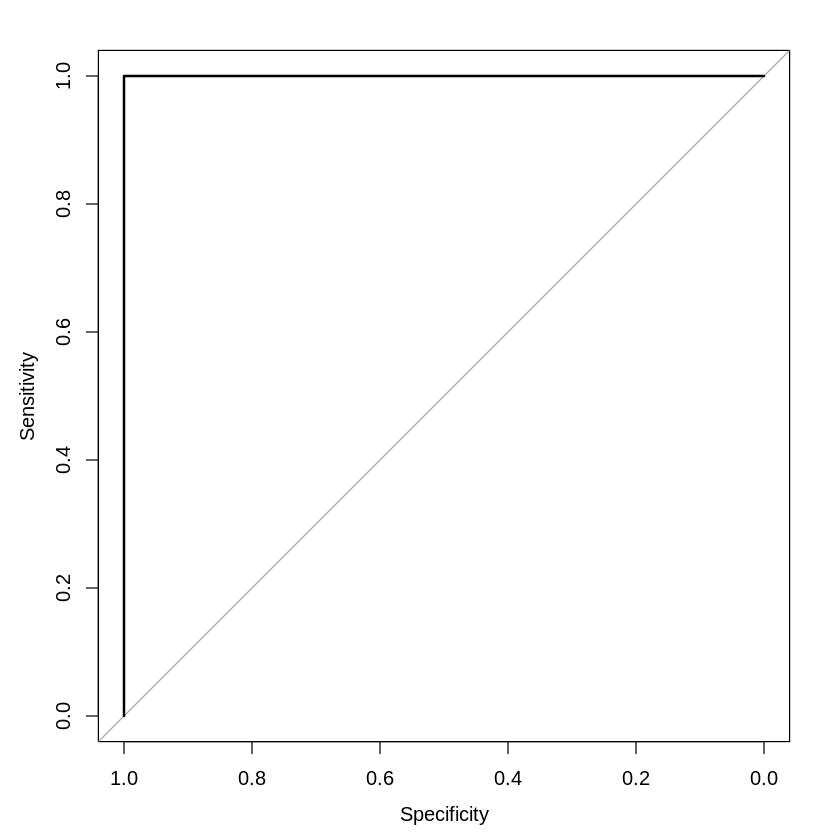

In [70]:
plot.roc(svm_AUC1_tr)

In [71]:
svm_PM1_tst=svm_cfm1_tst$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]


In [72]:
print("SVM Generalization-Phase Performance Parameters:")
svm_PM1_tst

[1] "SVM Generalization-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.7813551         0.2817680         1.0000000         0.5627102 
           Recall 
        1.0000000

In [73]:
svm_prob1_tst=predict(svm_model1, tstdf[, -which(names(tstdf)=="class")], type="raw")
svm_prob1_tst1 = ifelse(svm_prob1_tst > 1, "2", "1")

In [74]:
svm_AUC1_tst=roc(tstdf[, which(names(tstdf)=="class")],svm_prob1_tst)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



In [75]:
print(paste("SVM Generalization-Phase AUC:", round(svm_AUC1_tst$auc, 4)))

[1] "SVM Generalization-Phase AUC: 1"


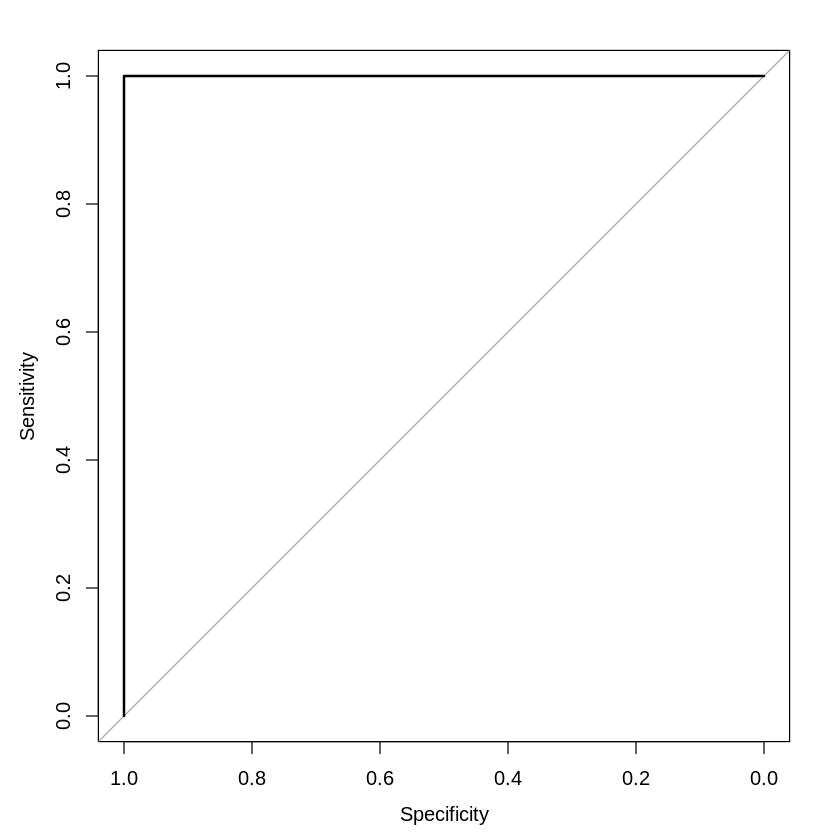

In [76]:
# ROC curves - Curve of Sensitivity and Specificity
plot.roc(svm_AUC1_tst)

In [77]:
svm_cfm1_tst

Confusion Matrix and Statistics

   svm_pred1_tst1
       1    2
  1  357  910
  2    0 1171
                                         
               Accuracy : 0.6267         
                 95% CI : (0.6072, 0.646)
    No Information Rate : 0.8536         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2737         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 1.0000         
            Specificity : 0.5627         
         Pos Pred Value : 0.2818         
         Neg Pred Value : 1.0000         
             Prevalence : 0.1464         
         Detection Rate : 0.1464         
   Detection Prevalence : 0.5197         
      Balanced Accuracy : 0.7814         
                                         
       'Positive' Class : 1              
                                         

In [78]:
# Variance Estimation for SVM

In [79]:
svm_varEst30=varEst(varEst_trdf, varEst_tstdf, 30, type="svm") # Variance estimation using 30% of the data


In [80]:
svm_varEst60=varEst(varEst_trdf, varEst_tstdf, 60, type="svm") # Variance estimation using 60% of the data


In [81]:
svm_varEst100=varEst(varEst_trdf, varEst_tstdf, 100, type="svm") # Variance estimation using 100% of the data


In [82]:
print("SVM Variance Estimation using 30% of data:")
svm_varEst30

[1] "SVM Variance Estimation using 30% of data:"


Mean of Accuracies,0.5237
Variance of Accuracies,0.0000


In [83]:
print("SVM Variance Estimation using 60% of data:")
svm_varEst60

[1] "SVM Variance Estimation using 60% of data:"


Mean of Accuracies,0.5237
Variance of Accuracies,0.0000


In [84]:
print("SVM Variance Estimation using 100% of data:")
svm_varEst100

[1] "SVM Variance Estimation using 100% of data:"


Mean of Accuracies,0.5237
Variance of Accuracies,0.0000


**Tree Algorithm**

In [85]:
# As we have many categorical variables, regression tree is an ideal classification tools for such situation.
# We’ll use the rpart package.

In [86]:
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [87]:
library(rpart)
library(rpart.plot)
tree_model1 = rpart(class~., data = trdf, method = 'class')


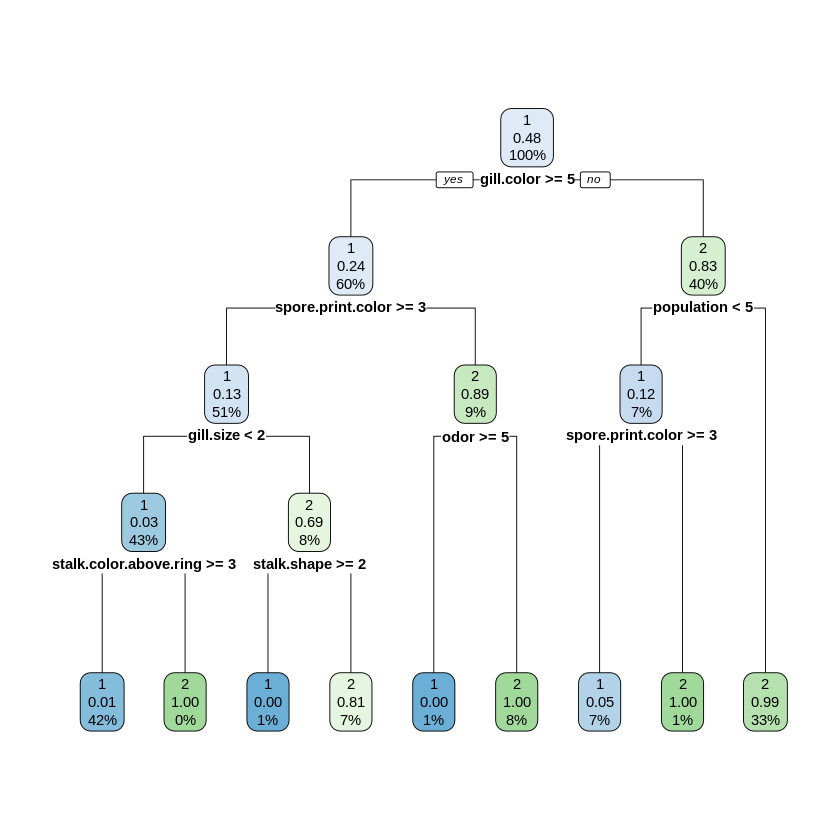

In [88]:
rpart.plot(tree_model1)

In [89]:
printcp(tree_model1)


Classification tree:
rpart(formula = class ~ ., data = trdf, method = "class")

Variables actually used in tree construction:
[1] gill.color             gill.size              odor                  
[4] population             spore.print.color      stalk.color.above.ring
[7] stalk.shape           

Root node error: 2745/5686 = 0.48276

n= 5686 

        CP nsplit rel error   xerror      xstd
1 0.561020      0  1.000000 1.000000 0.0137269
2 0.140255      1  0.438980 0.438980 0.0112263
3 0.112568      2  0.298725 0.298725 0.0096504
4 0.064845      3  0.186157 0.186157 0.0078563
5 0.024408      4  0.121311 0.121311 0.0064502
6 0.020765      5  0.096903 0.096903 0.0058009
7 0.011293      6  0.076138 0.076138 0.0051689
8 0.010200      7  0.064845 0.058652 0.0045565
9 0.010000      8  0.054645 0.048816 0.0041671


In [90]:
# Predict using train data (Learning Phase)
tree_pred1_tr=predict(tree_model1, trdf[, -which(names(trdf)=="class")],type="class")

In [91]:
tree_cfm1_tr=confusionMatrix(table(trdf[, which(names(trdf)=="class")],tree_pred1_tr)) # Confusion Matrix for train data


In [92]:
print("Tree Learning Phase Confusion Matrix")
tree_cfm1_tr

[1] "Tree Learning Phase Confusion Matrix"


Confusion Matrix and Statistics

   tree_pred1_tr
       1    2
  1 2841  100
  2   50 2695
                                          
               Accuracy : 0.9736          
                 95% CI : (0.9691, 0.9776)
    No Information Rate : 0.5084          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9472          
                                          
 Mcnemar's Test P-Value : 6.312e-05       
                                          
            Sensitivity : 0.9827          
            Specificity : 0.9642          
         Pos Pred Value : 0.9660          
         Neg Pred Value : 0.9818          
             Prevalence : 0.5084          
         Detection Rate : 0.4996          
   Detection Prevalence : 0.5172          
      Balanced Accuracy : 0.9735          
                                          
       'Positive' Class : 1               
                                          

In [93]:
tree_acc1_tr=round(tree_cfm1_tr$overall[["Accuracy"]],4) # Accuracy


In [94]:
print(paste("Tree Learning Phase Accuracy =",tree_acc1_tr))


[1] "Tree Learning Phase Accuracy = 0.9736"


In [95]:
tree_pred1_tst=predict(tree_model1, tstdf[, -which(names(trdf)=="class")], type = 'class')


In [96]:
tree_cfm1_tst=confusionMatrix(table(tstdf[, which(names(tstdf)=="class")],tree_pred1_tst)) # Confusion Matrix for test data


In [97]:
print("Tree Generalization-Phase Confusion Matrix")
tree_cfm1_tst

[1] "Tree Generalization-Phase Confusion Matrix"


Confusion Matrix and Statistics

   tree_pred1_tst
       1    2
  1 1211   56
  2   22 1149
                                          
               Accuracy : 0.968           
                 95% CI : (0.9602, 0.9746)
    No Information Rate : 0.5057          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.936           
                                          
 Mcnemar's Test P-Value : 0.0001866       
                                          
            Sensitivity : 0.9822          
            Specificity : 0.9535          
         Pos Pred Value : 0.9558          
         Neg Pred Value : 0.9812          
             Prevalence : 0.5057          
         Detection Rate : 0.4967          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.9678          
                                          
       'Positive' Class : 1               
                                          

In [98]:
tree_acc1_tst=round(tree_cfm1_tst$overall[["Accuracy"]],4) # Accuracy


In [99]:
print(paste("Tree Generalization-Phase Accuracy =",tree_acc1_tst))


[1] "Tree Generalization-Phase Accuracy = 0.968"


In [100]:
# Check for over-fitting. Criteria: Accuracy change from train to test > 25%
tree_model1_isOF=abs((tree_acc1_tr-tree_acc1_tst)/tree_acc1_tr)
tree_model1_isOF=round(tree_model1_isOF,4)
print(paste("Accuracy drop from training data to test data is",tree_model1_isOF*100,"%"))

[1] "Accuracy drop from training data to test data is 0.58 %"


In [101]:
if(tree_model1_isOF>0.25) print("Model is over-fitting") else print("Model is not over-fitting")


[1] "Model is not over-fitting"


In [102]:
tree_PM1_tr=tree_cfm1_tr$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]


In [103]:
print("Tree Learning-Phase Performance Parameters:")
tree_PM1_tr

[1] "Tree Learning-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.9734634         0.9659980         0.9827049         0.9642218 
           Recall 
        0.9827049

In [104]:
tree_prob1_tr=predict(tree_model1, trdf[, -which(names(trdf)=="class")], type = 'prob')


In [105]:
tree_prob1_tr1 = tree_prob1_tr[,2]


In [106]:
tree_AUC1_tr=multiclass.roc(trdf$class, tree_prob1_tr1, percent = TRUE)
print(paste("tree Learning-Phase AUC:",round(tree_AUC1_tr$auc,4)))

Setting direction: controls < cases



[1] "tree Learning-Phase AUC: 98.7602"


In [107]:
tree_ROC1_tr <- tree_AUC1_tr[['rocs']]


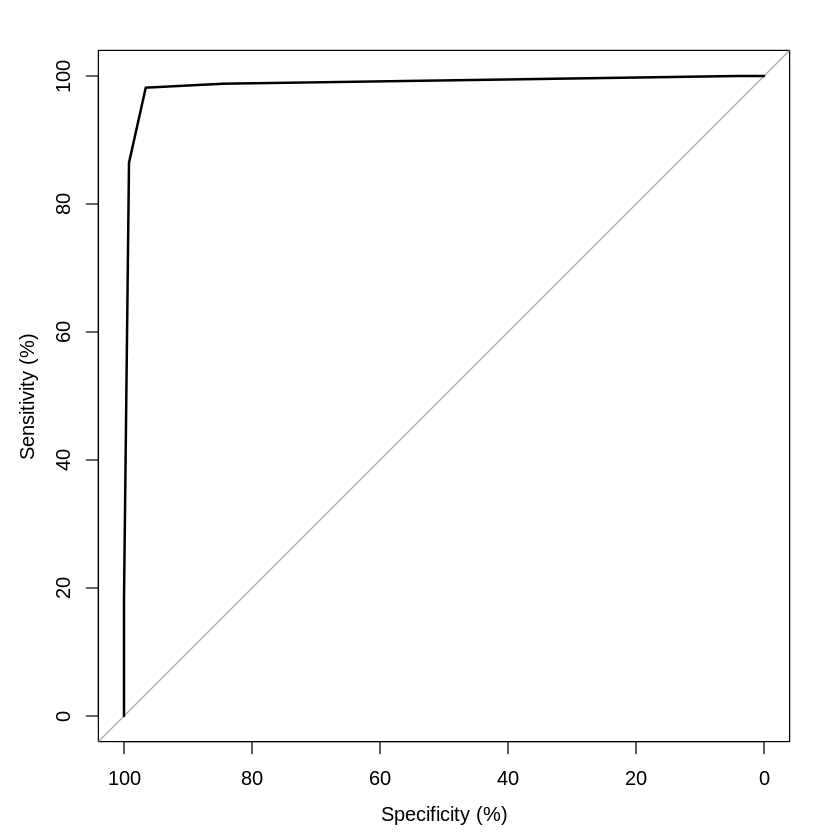

In [108]:
plot.roc(tree_ROC1_tr[[1]])


In [109]:
tree_PM1_tst=tree_cfm1_tst$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]


In [110]:
print("Tree Generalization-Phase Performance Parameters:")
tree_PM1_tst

[1] "Tree Generalization-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.9678422         0.9558011         0.9821573         0.9535270 
           Recall 
        0.9821573

In [111]:
tree_prob1_tst=predict(tree_model1, tstdf[, -which(names(tstdf)=="class")], type = 'prob')

In [112]:
tree_prob1_tst1 = tree_prob1_tst[,2]

In [113]:
tree_AUC1_tst=multiclass.roc(tstdf$class, tree_prob1_tst1, percent = TRUE)
print(paste("tree Generalization-Phase AUC:",round(tree_AUC1_tst$auc,4)))

Setting direction: controls < cases



[1] "tree Generalization-Phase AUC: 98.5677"


In [114]:
tree_ROC1_tst <- tree_AUC1_tst[['rocs']]

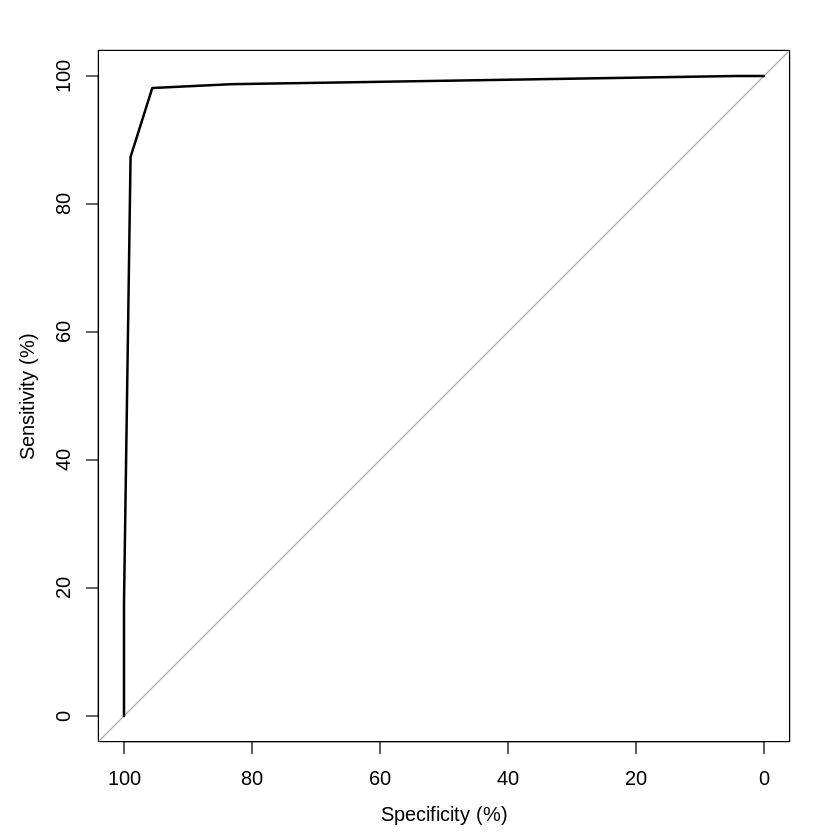

In [115]:
plot.roc(tree_ROC1_tst[[1]])

In [116]:
tree_cfm1_tst

Confusion Matrix and Statistics

   tree_pred1_tst
       1    2
  1 1211   56
  2   22 1149
                                          
               Accuracy : 0.968           
                 95% CI : (0.9602, 0.9746)
    No Information Rate : 0.5057          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.936           
                                          
 Mcnemar's Test P-Value : 0.0001866       
                                          
            Sensitivity : 0.9822          
            Specificity : 0.9535          
         Pos Pred Value : 0.9558          
         Neg Pred Value : 0.9812          
             Prevalence : 0.5057          
         Detection Rate : 0.4967          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.9678          
                                          
       'Positive' Class : 1               
                                          

In [117]:
# Variance Extimation for Tree

In [118]:
tree_varEst30=varEst(varEst_trdf, varEst_tstdf, 30, type="rpart") # Variance estimation using 30% of the data
tree_varEst60=varEst(varEst_trdf, varEst_tstdf, 60, type="rpart") # Variance estimation using 60% of the data
tree_varEst100=varEst(varEst_trdf, varEst_tstdf, 100, type="rpart") # Variance estimation using 100% of the data

In [119]:
print("Tree Variance Estimation using 30% of data:")
tree_varEst30

[1] "Tree Variance Estimation using 30% of data:"


Mean of Accuracies,9.650e-01
Variance of Accuracies,6.963e-05


In [120]:
print("Tree Variance Estimation using 60% of data:")
tree_varEst60

[1] "Tree Variance Estimation using 60% of data:"


Mean of Accuracies,9.633e-01
Variance of Accuracies,8.405e-05


In [121]:
print("Tree Variance Estimation using 100% of data:")
tree_varEst100

[1] "Tree Variance Estimation using 100% of data:"


Mean of Accuracies,0.9772
Variance of Accuracies,0.0000


**KNN - Nearest Neighbour**

In [122]:
trdf_knn=trdf[, -which(names(trdf)=="class")]

In [123]:
tstdf_knn=tstdf[, -which(names(trdf)=="class")]

In [124]:
trclass_knn=factor(trdf[, which(names(trdf)=="class")])

In [125]:
tstclass_knn=factor(tstdf[, which(names(tstdf)=="class")])

In [126]:
library(class)

In [127]:
knn_pred1=knn(trdf_knn,tstdf_knn,trclass_knn, k = 15, prob=TRUE)

In [128]:
# Predict using test data (Generalization Phase)
knn_cfm1_tst=confusionMatrix(table(tstclass_knn,knn_pred1)) # Confusion Matrix for test data

In [129]:
knn_cfm1_tst

Confusion Matrix and Statistics

            knn_pred1
tstclass_knn    1    2
           1 1264    3
           2   12 1159
                                          
               Accuracy : 0.9938          
                 95% CI : (0.9899, 0.9966)
    No Information Rate : 0.5234          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9877          
                                          
 Mcnemar's Test P-Value : 0.03887         
                                          
            Sensitivity : 0.9906          
            Specificity : 0.9974          
         Pos Pred Value : 0.9976          
         Neg Pred Value : 0.9898          
             Prevalence : 0.5234          
         Detection Rate : 0.5185          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.9940          
                                          
       'Positive' Class : 1               
                

In [130]:
knn_acc1_tst=round(knn_cfm1_tst$overall[["Accuracy"]],4) # Accuracy of predictions with test data

In [131]:
print(paste("kNN Generalization Phase Accuracy =",knn_acc1_tst))

[1] "kNN Generalization Phase Accuracy = 0.9938"


In [132]:
knn_PM1_tst=knn_cfm1_tst$byClass[c("Balanced Accuracy", "Precision", "Sensitivity", "Specificity", "Recall")]

In [133]:
print("kNN Generalization-Phase Performance Parameters:")
knn_PM1_tst

[1] "kNN Generalization-Phase Performance Parameters:"


Balanced Accuracy         Precision       Sensitivity       Specificity 
        0.9940069         0.9976322         0.9905956         0.9974182 
           Recall 
        0.9905956

In [134]:
knn_prob1_tst=attr(knn_pred1,"prob")

In [135]:
knn_AUC1_tst=multiclass.roc(tstclass_knn, as.ordered(knn_pred1))

Setting direction: controls < cases



In [136]:
print(paste("kNN Generalization-Phase AUC:",round(knn_AUC1_tst$auc,4)))

[1] "kNN Generalization-Phase AUC: 0.9937"


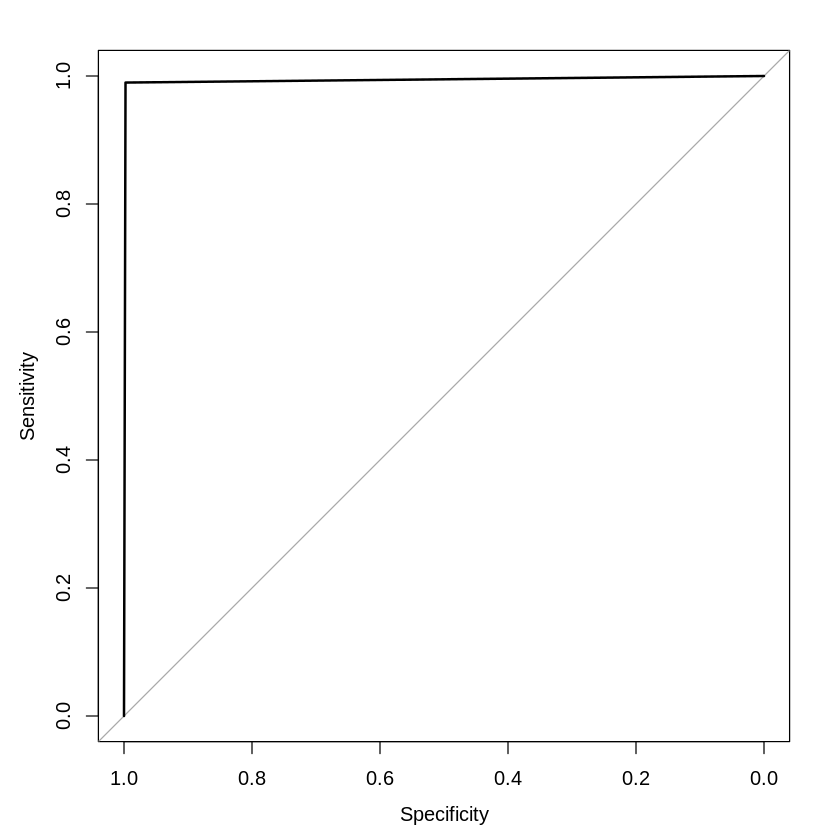

In [137]:
# ROC curves
knn_ROC1_tst=knn_AUC1_tst$rocs
plot.roc(knn_ROC1_tst[[1]], col=1)

In [138]:
knn_cfm1_tst

Confusion Matrix and Statistics

            knn_pred1
tstclass_knn    1    2
           1 1264    3
           2   12 1159
                                          
               Accuracy : 0.9938          
                 95% CI : (0.9899, 0.9966)
    No Information Rate : 0.5234          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9877          
                                          
 Mcnemar's Test P-Value : 0.03887         
                                          
            Sensitivity : 0.9906          
            Specificity : 0.9974          
         Pos Pred Value : 0.9976          
         Neg Pred Value : 0.9898          
             Prevalence : 0.5234          
         Detection Rate : 0.5185          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.9940          
                                          
       'Positive' Class : 1               
                

In [139]:
# Variance Estimation
knn_varEst30=varEst(varEst_trdf, varEst_tstdf, 30, type="knn") # 30% of data
knn_varEst60=varEst(varEst_trdf, varEst_tstdf, 60, type="knn") # 60% of data
knn_varEst100=varEst(varEst_trdf, varEst_tstdf, 100, type="knn") # 100% of data

In [140]:
print("kNN Variance Estimation using 30% of data:")
knn_varEst30

[1] "kNN Variance Estimation using 30% of data:"


Mean of Accuracies,0.9543000
Variance of Accuracies,0.0000405


In [141]:
print("kNN Variance Estimation using 60% of data:")
knn_varEst60

[1] "kNN Variance Estimation using 60% of data:"


Mean of Accuracies,9.761e-01
Variance of Accuracies,9.060e-06


In [142]:
print("kNN Variance Estimation using 100% of data:")
knn_varEst100

[1] "kNN Variance Estimation using 100% of data:"


Mean of Accuracies,9.889e-01
Variance of Accuracies,7.207e-07


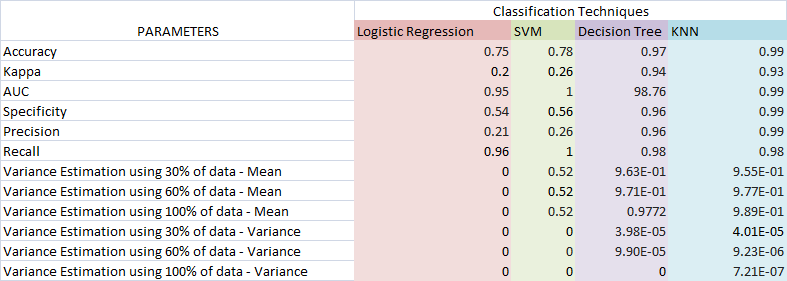

Variance tells you the degree of spread in your data set. The more spread the data, the larger the variance is in relation to the mean. As we can see the variance value is highest in SVM algorithm in relation to mean.

***Conclusion:***
If we only look at sensitivity(recall) and specificity then sensitivity is a measure of the proportion of actual positive cases that got predicted as positive (or true positive). Sensitivity is also termed as Recall. The higher value of sensitivity would mean higher value of true positive and lower value of false negative. The lower value of sensitivity would mean lower value of true positive and higher value of false negative. While Sensitivity measure is used to determine the proportion of actual positive cases, which got predicted correctly, Specificity measure is used to determine the proportion of actual negative cases, which got predicted correctly.Sensitivity and Specificity measures are used to plot the ROC curve. And, Area under ROC curve (AUC) is used to determine the model performance. For health related problems, models with high sensitivity will be desired. SVM is the model with high sensitivity(recall) and low specificity. But when we consider AUC then.

Comparing AUC's and Accuracy of all the Algorithms, the best algorithm to predict would be KNN as it has 99% accuracy as well as 2nd highest AUC. AUC is a better parameter to judge the completeness or viability of prediction as it is not hindered by the number of input variables used for training. Even if there was a 50% reduction or addition of test data, the AUC wouldn't change much as it is independent of the number of values given to the model.

Hence, taking into consideration both the parameters, KNN would be the most suitable one.